### Plot faculty hiring distribution by university

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from postdocsalary.paths import DATA_DIR, ensure_dir
import urllib.request
pd.set_option('display.max_columns', None)


<ipython-input-2-1570110eca21>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [127]:
university_df = pd.read_pickle(DATA_DIR/ 'university_ranking_salary.pickle')

In [4]:
university_df[:20]

,World Rank,Institution,Country,National Rank,Quality of Education Rank,Alumni Employment Rank,Quality of Faculty Rank,Research Performance Rank,Score,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,CHFTITLE,GENTELE,EIN,DUNS,OPEID,OPEFLAG,WEBADDR,ADMINURL,FAIDURL,APPLURL,NPRICURL,VETURL,ATHURL,DISAURL,SECTOR,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,HDEGOFR1,DEGGRANT,HBCU,HOSPITAL,MEDICAL,TRIBAL,LOCALE,OPENPUBL,ACT,NEWID,DEATHYR,CLOSEDAT,CYACTIVE,POSTSEC,PSEFLAG,PSET4FLG,RPTMTH,INSTCAT,C18BASIC,C18IPUG,C18IPGRD,C18UGPRF,C18ENPRF,C18SZSET,C15BASIC,CCBASIC,CARNEGIE,LANDGRNT,INSTSIZE,F1SYSTYP,F1SYSNAM,F1SYSCOD,CBSA,CBSATYPE,CSA,NECTA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG,LONGITUDE,CBSA_NAME,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
0,1.0,Harvard University,USA,1.0,1,1,1,1,100.0,166027.0,Harvard University,,Massachusetts Hall,Cambridge,MA,02138,25.0,1.0,Lawrence S. Bacow,President,6174951000,42103580.0,082359691|149617367|047006379,215500.0,1.0,www.harvard.edu/,college.harvard.edu/admissions,college.harvard.edu/financial-aid,college.harvard.edu/admissions/application-pro...,college.harvard.edu/financial-aid/net-price-ca...,sfs.harvard.edu/veteran-military-benefits,,accessibility.harvard.edu/,2.0,1.0,2.0,9.0,1.0,1.0,11.0,1.0,2.0,2.0,1.0,2.0,12.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,8.0,14.0,14.0,6.0,17.0,15.0,15.0,15.0,2.0,5.0,2.0,-2,-2.0,14460,1,148,71650.0,25017,Middlesex County,2505.0,-71.118313,42.374471,96.0,1.0,-71.118313,"Boston-Cambridge-Newton, MA-NH",115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079
1,2.0,Massachusetts Institute of Technology,USA,2.0,4,12,2,8,96.7,166683.0,Massachusetts Institute of Technology,"MIT, M.I.T.",77 Massachusetts Avenue,Cambridge,MA,02139-4307,25.0,1.0,L. Rafael Reif,President,6172531000,42103594.0,001425594,217800.0,1.0,web.mit.edu/,https://mitadmissions.org/,https://sfs.mit.edu/,my.mit.edu/,https://sfs.mit.edu/undergraduate-students/our...,https://sfs.mit.edu/undergraduate-students/typ...,,studentlife.mit.edu/das,2.0,1.0,2.0,9.0,1.0,1.0,12.0,1.0,2.0,2.0,2.0,2.0,12.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,14.0,15.0,14.0,6.0,17.0,15.0,15.0,15.0,1.0,4.0,2.0,-2,-2.0,14460,1,148,71650.0,25017,Middlesex County,2507.0,-71.093226,42.359243,96.0,1.0,-71.093226,"Boston-Cambridge-Newton, MA-NH",115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
2,3.0,Stanford University,USA,3.0,10,4,3,2,95.1,243744.0,Stanford University,,,Stanford,CA,94305,6.0,8.0,Marc Tessier-Lavigne,President,6507232300,941156365.0,009214214,130500.0,1.0,www.stanford.edu/,admission.stanford.edu/,financialaid.stanford.edu/,commonapp.org/,www.stanford.edu/dept/finaid/undergrad/how/cal...,exploredegrees.stanford.edu/veterans/,parents.stanford.edu/2015/11/09/stanford-athle...,diversityandaccess.stanford.edu/disability-access,2.0,1.0,2.0,9.0,1.0,1.0,11.0,1.0,2.0,1.0,1.0,2.0,21.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,11.0,14.0,14.0,6.0,17.0,15.0,15.0,15.0,2.0,4.0,2.0,-2,-2.0,41940,1,488,-2.0,6085,Santa Clara County,618.0,-122.167359,37.429434,96.0,1.0,-122.167359,"San Jose-Sunnyvale-Santa Clara, CA",126.7,62476.603840,349,63319.925605,62352.688787,49310.658122,49976.263303,49212.856186
3,6.0,Princeton University,USA,4.0,5,15,7,70,92.6,186131.0,Princeton University,,1 Nassau Hall,Princeton,NJ,08544-0070,34.0,2.0,Christopher L. Eisgruber,President,6092583000,210634501.0,002484665,262700.0,1.0,www.princeton.edu/,,,,www.princeton.edu/admission/financialaid/estim...,registrar.princeton.edu/student-services/veter...,fs.ncaa.org/Docs/newmedia/public/rates/index.html,www.princeton.edu/ods/,2.0,1.0,2.0,9.0,1.0,1.0,12.0,1.0,2.0,2.0,2.0,2.0,13.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,11.0,15.0,14.0,5.0,14.0,15.0,15.0,15.0,2.0,3.0,2.0,-2,-2.0,45940,1,408,-2.0,34021,Mercer County,3412.0,-74.659365,40.348732,96

### Hiring

In [5]:
Business_edgelist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'Business_edgelist.txt', sep='\t')
Business_vertexlist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'Business_vertexlist.txt', sep='\t')
ComputerScience_edgelist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'ComputerScience_edgelist.txt', sep='\t')
ComputerScience_vertexlist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'ComputerScience_vertexlist.txt', sep='\t')
History_edgelist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'History_edgelist.txt', sep='\t')
History_vertexlist = pd.read_csv(DATA_DIR/ 'faculty_hiring'/ 'History_vertexlist.txt', sep='\t')

In [6]:
ComputerScience_vertexlist

,# u,pi,USN2010,NRC95,Region,institution
0,1,2.23,1,1,West,Stanford University
1,2,2.31,1,3,West,UC Berkeley
2,3,3.52,1,2,Northeast,MIT
3,4,5.24,11,12,West,California Institute of Technology
4,5,6.12,17,11,Northeast,Harvard University
...,...,...,...,...,...,...
201,202,182.28,127,91,West,New Mexico Institute of Mining and Technology
202,203,182.47,.,92,West,"University of Nevada, Reno"
203,204,186.81,127,92,South,"University of Alabama, Tuscaloosa"
204,205,186.84,127,82,South,"University of North Texas, Denton"


In [7]:
len(History_vertexlist), len(ComputerScience_vertexlist), len(Business_vertexlist)

(145, 206, 113)

In [8]:
match_dict = {
    "University of Michigan": "University of Michigan, Ann Arbor",
    "University of Wisconsin, Madison": "University of Wisconsin–Madison",
    "University of Minnesota, Minneapolis": "University of Minnesota, Twin Cities",
    "University of Illinois, Urbana Champaign": "University of Illinois at Urbana–Champaign",
    "Purdue University": "Purdue University, West Lafayette",
    "Ohio State University": "Ohio State University, Columbus",
    "University of North Carolina, Chapel Hill": "University of North Carolina at Chapel Hill",
    "Washington University, St. Louis": "Washington University in St. Louis",
    "University of Texas, Austin": "University of Texas at Austin",
    "University of Pittsburgh": "University of Pittsburgh - Pittsburgh Campus",
    "Pennsylvania State University": "Pennsylvania State University, University Park",
    "University of Washington": "University of Washington - Seattle",
    "Indiana University": "Indiana University",
    "University of Colorado, Boulder": "University of Colorado Boulder",
    "UC Irvine": "University of California, Irvine",
    "State University of New York, Buffalo": "University at Buffalo, The State University of New York",
    "University of Texas, Dallas": "University of Texas at Dallas",
    "University of Massachusetts, Amherst": "University of Massachusetts Amherst",
    "Texas A&M": "Texas A&M University, College Station",
    "Claremont Graduate University": "",
    "University of South Carolina": "University of South Carolina - Columbia",
    "University of Oklahoma": "University of Oklahoma - Norman Campus",
    "Rutgers University": "Rutgers University-New Brunswick",
    "University of Kansas, Lawrence": "University of Kansas",
    "Louisiana State University": "Louisiana State University - Baton Rouge",
    "University of Arkansas, Fayetteville": "University of Arkansas - Fayetteville",
    "University of Alabama, Tuscaloosa": "University of Alabama - Tuscaloosa",
    "Oklahoma State University": "Oklahoma State University–Stillwater",
    "State University of New York, Binghamton": "Binghamton University",
    "CUNY Baruch College": "",
    "University of Hawaii, Manoa": "University of Hawaii at Manoa",
    "University of Mississippi": "University of Mississippi - Oxford Campus",
    "University of Missouri, St. Louis": "University of Missouri–St. Louis",
    "Worcester Polytechnic Institute": "",
    "Fordham University": "",
    "Santa Clara University": "",
    "Rollins College": "",
    "Miami University, Ohio": "Miami University",
    "Bentley University": "",
    "Texas Christian University": "",
    "Abilene Christian University": "",
    "Babson College": "",
    "Pepperdine University": "",
    "Thunderbird School of Global Management": "",
    "DePaul University": "",
    "Hofstra University": "",
    "University of Toronto": "",
    "UC San Diego": "University of California, San Diego",
    "State University of New York, Stony Brook": "Stony Brook University",
    "University of British Columbia": "",
    "UC Santa Barbara": "University of California, Santa Barbara",
    "University of Waterloo": "",
    "McGill University": "",
    "CUNY Graduate Center": "",
    "University of Montreal": "",
    "Simon Fraser University": "",
    "University of Illinois, Chicago": "University of Illinois at Chicago",
    "Stevens Institute of Technology": "",
    "McMaster University": "",
    "University of Alberta": "",
    "Polytechnic Institute of NYU": "",
    "University of Calgary": "",
    "University of Louisiana, Lafayette": "",
    "University of Western Ontario": "",
    "Carleton University": "",
    "Queens University": "",
    "University of Wisconsin, Milwaukee": "University of Wisconsin–Milwaukee",
    "University of Texas, Arlington": "University of Texas at Arlington",
    "University of Ottawa": "",
    "Oregon Health and Science University": "Oregon Health & Science University",
    "State University of New York, Albany": "University at Albany, SUNY",
    "University of South Florida": "University of South Florida - Tampa",
    "Colorado State University": "Colorado State University - Fort Collins",
    "University of Colorado, Denver": "University of Colorado Denver",
    "Toyota Technological Institute at Chicago": "",
    "University of Manitoba": "",
    "University of Regina": "",
    "University of Nebraska, Lincoln": "University of Nebraska–Lincoln",
    "University of Saskatchewan": "",
    "University of Texas, San Antonio": "University of Texas at San Antonio",
    "Oakland University (Michigan)": "Oakland University",
    "University of Maine": "University of Maine, Orono",
    "University of Victoria": "",
    "Concordia University, Montreal": "",
    "University of Missouri, Kansas City": "University of Missouri–Kansas City",
    "University of Missouri, Columbia": "University of Missouri–Columbia",
    "Dalhousie University": "",
    "Worcester Polytechnic Institute": "",
    "University of Texas, El Paso": "University of Texas at El Paso",
    "Naval Postgraduate School": "",
    "University of Massachusetts, Boston": "University of Massachusetts Boston",
    "York University": "",
    "Southern Illinois University, Carbondale": "Southern Illinois University Carbondale",
    "Claremont Graduate University": "",
    "Catholic University of America": "",
    "University of Massachusetts, Lowell": "University of Massachusetts Lowell",
    "University of North Carolina, Charlotte": "University of North Carolina at Charlotte",
    "University of Alabama, Birmingham": "University of Alabama at Birmingham",
    "Santa Clara University": "",
    "Montana State University": "Montana State University - Bozeman",
    "University of New Brunswick": "",
    "Wright State University": "Wright State University - Dayton",
    "Western Michigan University": "",
    "University of Alabama, Huntsville": "University of Alabama in Huntsville",
    "University of Idaho, Moscow": "University of Idaho",
    "Texas Tech University": "Texas Tech University (TTU)",
    "University of Tulsa": "",
    "Long Island University": "",
    "University of Colorado, Colorado Springs": "",
    "Memorial University of Newfoundland": "",
    "DePaul University": "",
    "Nova Southeastern University": "",
    "University of Bridgeport": "",
    "University of Nebraska, Omaha": "University of Nebraska Omaha",
    "University of Arkansas, Little Rock": "",
    "New Mexico Institute of Mining and Technology": "",
    "All others": "",
}

##### CS

In [17]:
match_list = []
for idx, row in ComputerScience_vertexlist.iterrows():
    match = None
    if row.institution in match_dict.keys():
        match = match_dict[row.institution]
    else:
        if row.institution in university_df.Institution.values:
            match = row.institution
        else:
            for ai, alias_list in enumerate(university_df.IALIAS.values):
                if type(alias_list) == str:
                    alias_list = alias_list.split(', ')
                    if row.institution in alias_list:
                        match = university_df.Institution.values[ai]
                        #match = alias_list[alias_list == row.institution]
    if match in ["", None]:
        print('"' + row.institution+'":"",')
    match_list.append(match)
    #if row.institution == 'MIT':
    #    breakme
ComputerScience_vertexlist['institution_name'] = match_list

# merge
ComputerScience_vertexlist = ComputerScience_vertexlist[["# u", "institution_name"]].merge(
    university_df[university_df.Institution.isnull() == False][["National Rank", "Institution"]],
    left_on="institution_name",
    right_on="Institution",
)

# count n hires
n_hires = []
for vertex in ComputerScience_vertexlist["# u"].values:
    n_hires.append(np.sum(ComputerScience_edgelist["# u"].values == vertex))
ComputerScience_vertexlist['n_hires'] = n_hires

"University of Toronto":"",
"University of British Columbia":"",
"University of Waterloo":"",
"McGill University":"",
"CUNY Graduate Center":"",
"College of William and Mary":"",
"University of Montreal":"",
"Simon Fraser University":"",
"Stevens Institute of Technology":"",
"Washington State University, Pullman":"",
"McMaster University":"",
"University of Alberta":"",
"Polytechnic Institute of NYU":"",
"University of Calgary":"",
"University of Louisiana, Lafayette":"",
"University of Western Ontario":"",
"Carleton University":"",
"Queens University":"",
"University of Ottawa":"",
"Toyota Technological Institute at Chicago":"",
"University of Manitoba":"",
"University of Regina":"",
"University of Saskatchewan":"",
"University of Victoria":"",
"Concordia University, Montreal":"",
"Dalhousie University":"",
"Worcester Polytechnic Institute":"",
"Naval Postgraduate School":"",
"York University":"",
"Claremont Graduate University":"",
"Catholic University of America":"",
"Santa Clara Un

In [18]:
match

''

In [19]:
len(ComputerScience_vertexlist)

144

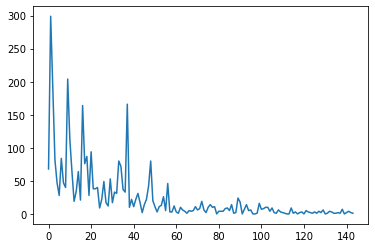

In [20]:
plt.plot(ComputerScience_vertexlist.sort_values(by='National Rank').n_hires.values)

#### History

In [21]:
match_list = []
for idx, row in Business_vertexlist.iterrows():
    match = None
    if row.institution in match_dict.keys():
        match = match_dict[row.institution]
    else:
        if row.institution in university_df.Institution.values:
            match = row.institution
        else:
            for ai, alias_list in enumerate(university_df.IALIAS.values):
                if type(alias_list) == str:
                    alias_list = alias_list.split(', ')
                    if row.institution in alias_list:
                        match = university_df.Institution.values[ai]
                        #match = alias_list[alias_list == row.institution]
    if match in ["", None]:
        print('"' + row.institution+'":"",')
    match_list.append(match)
Business_vertexlist['institution_name'] = match_list

# merge
Business_vertexlist = Business_vertexlist[["# u", "institution_name"]].merge(
    university_df[university_df.Institution.isnull() == False][["National Rank", "Institution"]],
    left_on="institution_name",
    right_on="Institution",
)

# count n hires
n_hires = []
for vertex in Business_vertexlist["# u"].values:
    n_hires.append(np.sum(Business_edgelist["# u"].values == vertex))
Business_vertexlist['n_hires'] = n_hires

"Claremont Graduate University":"",
"CUNY Baruch College":"",
"Worcester Polytechnic Institute":"",
"College of William and Mary":"",
"Fordham University":"",
"Santa Clara University":"",
"Rollins College":"",
"Bentley University":"",
"Texas Christian University":"",
"Abilene Christian University":"",
"Babson College":"",
"Pepperdine University":"",
"Thunderbird School of Global Management":"",
"DePaul University":"",
"Hofstra University":"",
"All others":"",


In [22]:
#[i for i in [j for j in university_df.Institution.values if type(j) == str] if "Minnesota" in i]

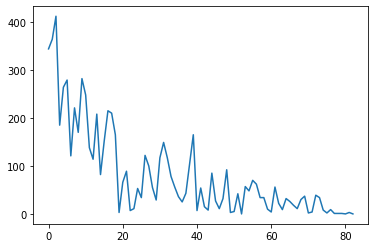

In [23]:
plt.plot(Business_vertexlist.sort_values(by='National Rank').n_hires.values)

In [24]:
#[i for i in [j for j in university_df.Institution.values if type(j) == str] if "New Mexico" in i]

### History

In [25]:
match_list = []
for idx, row in History_vertexlist.iterrows():
    match = None
    if row.institution in match_dict.keys():
        match = match_dict[row.institution]
    else:
        if row.institution in university_df.Institution.values:
            match = row.institution
        else:
            for ai, alias_list in enumerate(university_df.IALIAS.values):
                if type(alias_list) == str:
                    alias_list = alias_list.split(', ')
                    if row.institution in alias_list:
                        match = university_df.Institution.values[ai]
                        #match = alias_list[alias_list == row.institution]
    if match in ["", None]:
        print('"' + row.institution+'":"",')
    match_list.append(match)
History_vertexlist['institution_name'] = match_list
print(len(History_vertexlist))
# merge
History_vertexlist = History_vertexlist[["# u", "institution_name"]].merge(
    university_df[university_df.Institution.isnull() == False][["National Rank", "Institution"]],
    left_on="institution_name",
    right_on="Institution",
)
print(len(History_vertexlist))
# count n hires
n_hires = []
for vertex in History_vertexlist["# u"].values:
    n_hires.append(np.sum(History_edgelist["# u"].values == vertex))
History_vertexlist['n_hires'] = n_hires

"Catholic University of America":"",
"Claremont Graduate University":"",
"Princeton Theological Seminary":"",
"College of William and Mary":"",
"American University, Washington":"",
"CUNY Graduate Center":"",
"Washington State University, Pullman":"",
"Jewish Theological Seminary of America":"",
"Saint Johns University":"",
"Texas Christian University":"",
"Graduate Theological Union":"",
"Fordham University":"",
"Southern Baptist Theological Seminary":"",
"Western Michigan University":"",
"Middle Tennessee State University":"",
"All others":"",
145
116


In [26]:
History_vertexlist

,# u,institution_name,National Rank,Institution,n_hires
0,1,Harvard University,1.0,Harvard University,324
1,2,Yale University,8.0,Yale University,307
2,3,"University of California, Berkeley",10.0,"University of California, Berkeley",246
3,4,Princeton University,4.0,Princeton University,184
4,5,Stanford University,3.0,Stanford University,172
...,...,...,...,...,...
111,137,University of Texas at Arlington,151.0,University of Texas at Arlington,0
112,138,University of Idaho,181.0,University of Idaho,0
113,140,University of Memphis,215.0,University of Memphis,1
114,141,Mississippi State University,171.0,Mississippi State University,0


In [27]:
History_vertexlist.institution_name.values

array(['Harvard University', 'Yale University',
       'University of California, Berkeley', 'Princeton University',
       'Stanford University', 'University of Chicago',
       'Columbia University', 'Brandeis University',
       'Johns Hopkins University', 'University of Pennsylvania',
       'University of Wisconsin–Madison',
       'University of Michigan, Ann Arbor',
       'University of California, Los Angeles', 'Northwestern University',
       'Cornell University', 'Brown University',
       'University of California, Davis', 'University of Rochester',
       'New York University', 'University of California, San Diego',
       'University of California, San Diego', 'Duke University',
       'University of North Carolina at Chapel Hill',
       'University of Virginia', 'University of Southern California',
       'University of Washington - Seattle',
       'Massachusetts Institute of Technology',
       'University of Texas at Austin', 'Emory University',
       'Stony Brook 

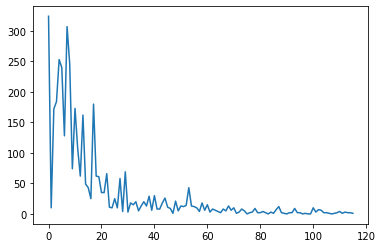

In [28]:
plt.plot(History_vertexlist.sort_values(by='National Rank').n_hires.values)

### Sort by number of hires

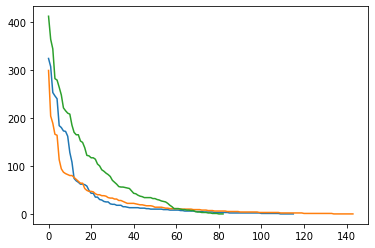

In [29]:
plt.plot(History_vertexlist.sort_values(by='n_hires', ascending=False).n_hires.values)
plt.plot(ComputerScience_vertexlist.sort_values(by='n_hires', ascending=False).n_hires.values)
plt.plot(Business_vertexlist.sort_values(by='n_hires', ascending=False).n_hires.values)

In [30]:
Business_vertexlist.sort_values(by='n_hires', ascending=False)[:20]

,# u,institution_name,National Rank,Institution,n_hires
0,1,Stanford University,3.0,Stanford University,412
1,2,Massachusetts Institute of Technology,2.0,Massachusetts Institute of Technology,364
2,3,Harvard University,1.0,Harvard University,344
8,9,"University of Michigan, Ann Arbor",12.0,"University of Michigan, Ann Arbor",282
11,12,University of Pennsylvania,7.0,University of Pennsylvania,279
5,6,University of Chicago,6.0,University of Chicago,264
7,8,Northwestern University,14.0,Northwestern University,248
3,4,"University of California, Berkeley",10.0,"University of California, Berkeley",221
15,16,New York University,20.0,New York University,215
22,26,University of Texas at Austin,21.0,University of Texas at Austin,210


In [31]:
ComputerScience_vertexlist.sort_values(by='n_hires', ascending=False)[:20]

,# u,institution_name,National Rank,Institution,n_hires
2,3,Massachusetts Institute of Technology,2.0,Massachusetts Institute of Technology,299
1,2,"University of California, Berkeley",10.0,"University of California, Berkeley",204
0,1,Stanford University,3.0,Stanford University,189
6,7,Carnegie Mellon University,46.0,Carnegie Mellon University,166
10,11,University of Illinois at Urbana–Champaign,17.0,University of Illinois at Urbana–Champaign,164
5,6,Cornell University,11.0,Cornell University,113
17,18,University of Texas at Austin,21.0,University of Texas at Austin,94
11,12,University of Wisconsin–Madison,19.0,University of Wisconsin–Madison,87
12,13,University of Pennsylvania,7.0,University of Pennsylvania,84
7,8,Princeton University,4.0,Princeton University,82


In [32]:
History_vertexlist.sort_values(by='n_hires', ascending=False)[:20]

,# u,institution_name,National Rank,Institution,n_hires
0,1,Harvard University,1.0,Harvard University,324
1,2,Yale University,8.0,Yale University,307
6,7,Columbia University,5.0,Columbia University,253
2,3,"University of California, Berkeley",10.0,"University of California, Berkeley",246
5,6,University of Chicago,6.0,University of Chicago,240
3,4,Princeton University,4.0,Princeton University,184
10,11,University of Wisconsin–Madison,19.0,University of Wisconsin–Madison,180
11,12,"University of Michigan, Ann Arbor",12.0,"University of Michigan, Ann Arbor",173
4,5,Stanford University,3.0,Stanford University,172
12,13,"University of California, Los Angeles",15.0,"University of California, Los Angeles",162


### Hiring rate for PhDs

In [80]:
joined_hires_df = (
    History_vertexlist[["Institution", "n_hires"]]
    .merge(
        ComputerScience_vertexlist[["Institution", "n_hires"]],
        on="Institution",
        how='outer',
        suffixes=("", "_CS"),
    )
    .merge(
        Business_vertexlist[["Institution", "n_hires"]],
        on="Institution",
        how='outer',
        suffixes=("_His", "_Bus"),
    )
)
joined_hires_df["total_hires"] = np.nansum(
    [joined_hires_df["n_hires_His"]
    , joined_hires_df["n_hires_CS"]
    , joined_hires_df["n_hires_Bus"]], axis = 0
)
joined_hires_df = joined_hires_df.sort_values(by='total_hires', ascending=False)
# ,

In [81]:
joined_hires_df[:10]

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires
4,Stanford University,172.0,189.0,412.0,773.0
0,Harvard University,324.0,68.0,344.0,736.0
28,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0
2,"University of California, Berkeley",246.0,204.0,221.0,671.0
5,University of Chicago,240.0,28.0,264.0,532.0
11,"University of Michigan, Ann Arbor",173.0,64.0,282.0,519.0
9,University of Pennsylvania,128.0,84.0,279.0,491.0
6,Columbia University,253.0,47.0,185.0,485.0
1,Yale University,307.0,47.0,121.0,475.0
10,University of Wisconsin–Madison,180.0,87.0,152.0,419.0


In [82]:
len(joined_hires_df)

165

In [83]:
survey_df = pd.read_pickle(DATA_DIR/ 'nsf_survey'/ 'phds_2013_simplified_counts.csv')

In [84]:
def strip_name(name):
    return ''.join(filter( lambda x: x in '0123456789abcdefghijklmnopqrstuvwxyz', name.lower()))

In [85]:
hand_matched = {
    "Stanford University": "Stanford University, Stanford ",
    "University of Chicago": "University Chicago ",
    "Columbia University": "Columbia University in the City of New York ",
    "University of Illinois at Urbana–Champaign": "University of Illinois, Urbana-Champaign ",
    "University of Texas at Austin": "University of Texas, Austin ",
    "University of North Carolina at Chapel Hill": "University of North Carolina, Chapel Hill ",
    "University of Rochester": "University Rochester ",
    "University of Southern California": "University Southern California ",
    "University of Virginia": "University of Virginia, Charlottesville ",
    "Washington University in St. Louis": "Washington University, St. Louis ",
    "University of Houston": "University Houston ",
    "University of Cincinnati": "University Cincinnati, Uptown West Campus ",
    "University of Connecticut": "University of Connecticut, Storrs ",
    "University of Notre Dame": "University Notre Dame ",
    "University of Texas at Dallas": "University of Texas, Dallas ",
    "Binghamton University": "SUNY, Binghamton University ",
    "Auburn University": "Auburn University, Auburn ",
    "University of Hawaii at Manoa": "University of Hawaii, Manoa ",
    "University of Miami": "University Miami ",
    "Stony Brook University": "SUNY, Stony Brook University ",
    "University of New Mexico": "University of New Mexico, Albuquerque ",
    "University of Illinois at Chicago": "University of Illinois, Chicago ",
    "Ohio University": "Ohio University, Chillicothe ",
    "University of Toledo": "University Toledo ",
    "University of New Hampshire": "University of New Hampshire, Durham ",
    "University at Albany, SUNY": "SUNY, University Albany ",
    "Kent State University": "Kent State University, Kent ",
    "Bowling Green State University": "Bowling Green State University, Bowling Green ",
    "University of Maine, Orono": "University of Maine ",
    "Miami University": "Miami University, Oxford ",
    "University of North Texas, Denton": "University North Texas, Denton ",
    "University of Southern Mississippi": "University Southern Mississippi ",
    "University of Akron": "University Akron, Akron ",
    "Saint Louis University": "St. Louis University ",
    "University of Texas at Arlington": "University of Texas, Arlington ",
    "University of Memphis": "University Memphis ",
    "Rensselaer Polytechnic Institute": "Rensselaer Polytechnic University, Troy ",
    "University of Central Florida": "University Central Florida ",
    "Oregon Health & Science University": "Oregon Health and Science University ",
    "Virginia Tech": "Virginia Polytechnic Institute and State University ",
    "Oregon State University": "Oregon State University, Corvallis ",
    "University of Texas at San Antonio": "University of Texas, San Antonio ",
    "University of Denver": "University Denver ",
    "New Mexico State University": "New Mexico State University, Las Cruces ",
    #"Virginia Commonwealth University": "University of Virginia",
    "University of Texas at El Paso": "University of Texas, El Paso ",
    "University of North Carolina at Charlotte": "University of North Carolina, Charlotte ",
    "University of Alabama at Birmingham": "University of Alabama, Birmingham ",
    "University of Alabama in Huntsville": "University of Alabama, Huntsville ",
    "Brigham Young University": "Brigham Young University, Provo ",
    "Utah State University": "Utah State University, Logan ",
    "University of Louisville": "University Louisville ",
    #'University of Virginia':'',
    #'Stony Brook University':'',
}

In [86]:
# fix hand matched
for key, value in hand_matched.items():
    survey_df.loc[survey_df.Institution == value, "Institution"] = key

In [87]:
survey_df['stripped_name'] = survey_df.Institution.apply(strip_name)
joined_hires_df['stripped_name'] = joined_hires_df.Institution.apply(strip_name)

In [88]:
len(joined_hires_df)

165

In [89]:
joined_hires_df = joined_hires_df.drop_duplicates()

In [90]:
len(joined_hires_df.drop_duplicates())

162

In [91]:
joined_hires_df_merged = joined_hires_df.merge(survey_df, on='stripped_name', how='left', suffixes=('', '_nsf_name'))
joined_hires_df_merged['hire_ratio'] = joined_hires_df_merged['total_hires'] / joined_hires_df_merged['n_grads']
joined_hires_df_merged = joined_hires_df_merged.sort_values(by='hire_ratio', ascending=False)
joined_hires_df_merged

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,stripped_name,Institution_nsf_name,n_grads,hire_ratio
4,University of Chicago,240.0,28.0,264.0,532.0,universityofchicago,University of Chicago,412.0,1.291262
8,Yale University,307.0,47.0,121.0,475.0,yaleuniversity,Yale University,393.0,1.208651
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,massachusettsinstituteoftechnology,Massachusetts Institute of Technology,587.0,1.146508
6,University of Pennsylvania,128.0,84.0,279.0,491.0,universityofpennsylvania,University of Pennsylvania,443.0,1.108352
1,Harvard University,324.0,68.0,344.0,736.0,harvarduniversity,Harvard University,674.0,1.091988
...,...,...,...,...,...,...,...,...,...
157,University of Akron,0.0,NaN,NaN,0.0,universityofakron,University of Akron,97.0,0.000000
158,University of Louisville,NaN,0.0,NaN,0.0,universityoflouisville,University of Louisville,134.0,0.000000
159,University of Massachusetts Lowell,NaN,0.0,NaN,0.0,universityofmassachusettslowell,"University of Massachusetts, Lowell",66.0,0.000000
160,Wake Forest University,NaN,NaN,0.0,0.0,wakeforestuniversity,Wake Forest University,48.0,0.000000


In [92]:
for i in joined_hires_df_merged[joined_hires_df_merged.Institution_nsf_name.isnull()].Institution.values:
    print("'{}':'',".format(i))
#print([i for i in survey_df.Institution.values if strip_name(i) not in joined_hires_df_merged.stripped_name])    

In [93]:
joined_hires_df[:3]

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,stripped_name
4,Stanford University,172.0,189.0,412.0,773.0,stanforduniversity
0,Harvard University,324.0,68.0,344.0,736.0,harvarduniversity
28,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,massachusettsinstituteoftechnology


In [94]:
len(joined_hires_df_merged)

162

In [95]:
joined_hires_df_merged = joined_hires_df_merged.merge(university_df, on="Institution", how='left')
len(joined_hires_df_merged)

163

In [96]:
joined_hires_df_merged

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,stripped_name,Institution_nsf_name,n_grads,hire_ratio,World Rank,Country,National Rank,Quality of Education Rank,Alumni Employment Rank,Quality of Faculty Rank,Research Performance Rank,Score,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,CHFTITLE,GENTELE,EIN,DUNS,OPEID,OPEFLAG,WEBADDR,ADMINURL,FAIDURL,APPLURL,NPRICURL,VETURL,ATHURL,DISAURL,SECTOR,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,HDEGOFR1,DEGGRANT,HBCU,HOSPITAL,MEDICAL,TRIBAL,LOCALE,OPENPUBL,ACT,NEWID,DEATHYR,CLOSEDAT,CYACTIVE,POSTSEC,PSEFLAG,PSET4FLG,RPTMTH,INSTCAT,C18BASIC,C18IPUG,C18IPGRD,C18UGPRF,C18ENPRF,C18SZSET,C15BASIC,CCBASIC,CARNEGIE,LANDGRNT,INSTSIZE,F1SYSTYP,F1SYSNAM,F1SYSCOD,CBSA,CBSATYPE,CSA,NECTA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG,LONGITUDE,CBSA_NAME,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
0,University of Chicago,240.0,28.0,264.0,532.0,universityofchicago,University of Chicago,412.0,1.291262,8.0,USA,6.0,8,16,27,22,91.5,144050.0,University of Chicago,,5801 S Ellis Ave,Chicago,IL,60637,17.0,3.0,Robert J. Zimmer,President,7737021234,362177139.0,005421136,177400.0,1.0,www.uchicago.edu/,collegeadmissions.uchicago.edu/,financialaid.uchicago.edu/,https://collegeadmissions.uchicago.edu/apply/,https://collegeadmissions.uchicago.edu/costs/c...,https://registrar.uchicago.edu/records/veteran...,,disabilities.uchicago.edu/,2.0,1.0,2.0,9.0,1.0,1.0,11.0,1.0,2.0,2.0,1.0,2.0,11.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,8.0,14.0,14.0,6.0,17.0,15.0,15.0,15.0,2.0,4.0,2.0,-2,-2.0,16980,1,176,-2.0,17031,Cook County,1701.0,-87.599539,41.787994,96.0,1.0,-87.599539,"Chicago-Naperville-Elgin, IL-IN-WI",102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534
1,Yale University,307.0,47.0,121.0,475.0,yaleuniversity,Yale University,393.0,1.208651,10.0,USA,8.0,6,36,13,20,90.7,130794.0,Yale University,,Woodbridge Hall,New Haven,CT,06520,9.0,1.0,Peter Salovey,President,2034324771,60646973.0,043207562,142600.0,1.0,https://www.yale.edu/,https://admissions.yale.edu/,https://finaid.yale.edu/,https://admissions.yale.edu/first-year-applica...,https://admissions.yale.edu/estimate-your-cost,finaid.yale.edu/costs-affordability/types-aid/...,yalebulldogs.com/documents/2019/7/18//Athletic...,https://sas.yale.edu/,2.0,1.0,2.0,9.0,1.0,1.0,11.0,1.0,2.0,2.0,1.0,2.0,12.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,8.0,14.0,14.0,6.0,17.0,15.0,15.0,15.0,2.0,4.0,2.0,-2,-2.0,35300,1,408,75700.0,9009,New Haven County,903.0,-72.926688,41.311158,96.0,1.0,-72.926688,"New Haven-Milford, CT",106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,massachusettsinstituteoftechnology,Massachusetts Institute of Technology,587.0,1.146508,2.0,USA,2.0,4,12,2,8,96.7,166683.0,Massachusetts Institute of Technology,"MIT, M.I.T.",77 Massachusetts Avenue,Cambridge,MA,02139-4307,25.0,1.0,L. Rafael Reif,President,6172531000,42103594.0,001425594,217800.0,1.0,web.mit.edu/,https://mitadmissions.org/,https://sfs.mit.edu/,my.mit.edu/,https://sfs.mit.edu/undergraduate-students/our...,https://sfs.mit.edu/undergraduate-students/typ...,,studentlife.mit.edu/das,2.0,1.0,2.0,9.0,1.0,1.0,12.0,1.0,2.0,2.0,2.0,2.0,12.0,1.0,A,-2.0,-2.0,-2,1.0,1.0,1.0,1.0,1.0,2.0,15.0,14.0,15.0,14.0,6.0,17.0,15.0,15.0,15.0,1.0,4.0,2.0,-2,-2.0,14460,1,148,71650.0,25017,Middlesex County,2507.0,-71.093226,42.359243,96.0,1.0,-71.093226,"Boston-Cambridge-Newton, MA-NH",115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
3,University of Pennsylvania,128.0,84.0,279.0,491.0,universityofpennsylvania,University of Pennsylvania,443.0,1.108352,9.0,USA,7.0,14,10,42,12,91.1,215062.0,University of Pennsylvania,"Penn, U of PA, U-Penn, U of P, Pennsylvania, U...",34th & Spruce Street,Philadelphia,PA,19104-63

In [97]:
joined_hires_df_merged_subset = joined_hires_df_merged[
    [
        "Institution",
        "n_hires_His",
        "n_hires_CS",
        "n_hires_Bus",
        "total_hires",
        "hire_ratio",
        "RPP_all",
        "MEDIAN_SALARY",
        "N_SALARIES",
        "MEDIAN_SALARY_UPPER",
        "MEDIAN_SALARY_LOWER",
        "REAL_MEDIAN_SALARY",
        "REAL_MEDIAN_SALARY_UPPER",
        "REAL_MEDIAN_SALARY_LOWER",
    ]
]

In [98]:
joined_hires_df_merged_subset

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
0,University of Chicago,240.0,28.0,264.0,532.0,1.291262,102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534
1,Yale University,307.0,47.0,121.0,475.0,1.208651,106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,1.146508,115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
3,University of Pennsylvania,128.0,84.0,279.0,491.0,1.108352,105.3,55205.642506,534,55913.661314,54938.156376,52427.010927,53099.393461,52172.988011
4,Harvard University,324.0,68.0,344.0,736.0,1.091988,115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,University of Akron,0.0,NaN,NaN,0.0,0.000000,90.0,40648.647640,11,50921.362510,36550.988169,45165.164044,56579.291677,40612.209077
159,University of Louisville,NaN,0.0,NaN,0.0,0.000000,89.6,50102.946467,61,50331.090389,49337.604214,55918.467039,56173.091952,55064.290418
160,University of Massachusetts Lowell,NaN,0.0,NaN,0.0,0.000000,115.5,NaN,0,NaN,NaN,NaN,NaN,NaN
161,Wake Forest University,NaN,NaN,0.0,0.0,0.000000,88.7,NaN,0,NaN,NaN,NaN,NaN,NaN


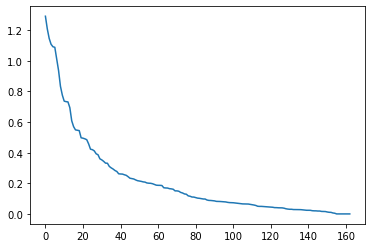

In [99]:
plt.plot(joined_hires_df_merged_subset.hire_ratio.values)

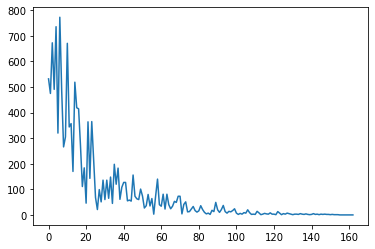

In [100]:
plt.plot(joined_hires_df_merged_subset.total_hires.values)

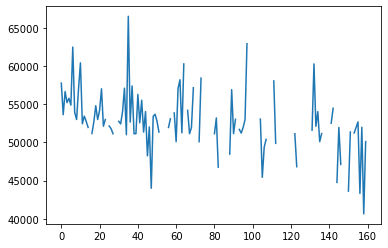

In [101]:
plt.plot(joined_hires_df_merged_subset.MEDIAN_SALARY.values)

In [102]:
joined_hires_df_merged_subset.sort_values(by='total_hires', ascending=False)[:25]

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
6,Stanford University,172.0,189.0,412.0,773.0,1.013106,126.7,62476.603840,349,63319.925605,62352.688787,49310.658122,49976.263303,49212.856186
4,Harvard University,324.0,68.0,344.0,736.0,1.091988,115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,1.146508,115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
10,"University of California, Berkeley",246.0,204.0,221.0,671.0,0.736553,134.5,60413.982812,331,61417.398455,59110.348970,44917.459340,45663.493275,43948.214848
0,University of Chicago,240.0,28.0,264.0,532.0,1.291262,102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534
14,"University of Michigan, Ann Arbor",173.0,64.0,282.0,519.0,0.608441,100.6,51964.730835,1205,51964.730835,51964.730835,51654.802023,51654.802023,51654.802023
3,University of Pennsylvania,128.0,84.0,279.0,491.0,1.108352,105.3,55205.642506,534,55913.661314,54938.156376,52427.010927,53099.393461,52172.988011
7,Columbia University,253.0,47.0,185.0,485.0,0.936293,125.7,53930.481535,471,54877.268858,53390.528986,42904.122144,43657.334016,42474.565621
1,Yale University,307.0,47.0,121.0,475.0,1.208651,106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155
15,University of Wisconsin–Madison,180.0,87.0,152.0,419.0,0.570068,96.4,NaN,0,NaN,NaN,NaN,NaN,NaN


In [103]:
joined_hires_df_merged_subset

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
0,University of Chicago,240.0,28.0,264.0,532.0,1.291262,102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534
1,Yale University,307.0,47.0,121.0,475.0,1.208651,106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,1.146508,115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
3,University of Pennsylvania,128.0,84.0,279.0,491.0,1.108352,105.3,55205.642506,534,55913.661314,54938.156376,52427.010927,53099.393461,52172.988011
4,Harvard University,324.0,68.0,344.0,736.0,1.091988,115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,University of Akron,0.0,NaN,NaN,0.0,0.000000,90.0,40648.647640,11,50921.362510,36550.988169,45165.164044,56579.291677,40612.209077
159,University of Louisville,NaN,0.0,NaN,0.0,0.000000,89.6,50102.946467,61,50331.090389,49337.604214,55918.467039,56173.091952,55064.290418
160,University of Massachusetts Lowell,NaN,0.0,NaN,0.0,0.000000,115.5,NaN,0,NaN,NaN,NaN,NaN,NaN
161,Wake Forest University,NaN,NaN,0.0,0.0,0.000000,88.7,NaN,0,NaN,NaN,NaN,NaN,NaN


In [123]:
joined_hires_df_merged_subset[joined_hires_df_merged_subset.Institution == 'University of California, San Diego']

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
69,"University of California, San Diego",35.0,38.0,NaN,73.0,0.150515,117.9,57156.631388,532,58150.207767,56903.063787,48478.90703,49321.635086,48263.83697
70,"University of California, San Diego",35.0,38.0,NaN,73.0,0.150515,117.9,NaN,0,NaN,NaN,NaN,NaN,NaN


In [122]:
# list universities where we do not have data
joined_hires_df_merged_subset[joined_hires_df_merged_subset.MEDIAN_SALARY.isnull()].Institution.values[]

array(['University of Wisconsin–Madison', 'Michigan State University',
       'Boston College', 'University of Virginia',
       'University of Arkansas - Fayetteville',
       'University of Texas at Dallas',
       'University of Tennessee, Knoxville', 'University of Florida',
       'Binghamton University', 'University of California, San Diego',
       'University of Alabama in Huntsville', 'Dartmouth College',
       'University of New Mexico', 'Kansas State University',
       'Brigham Young University', 'Illinois Institute of Technology',
       'Northern Illinois University', 'University of Central Florida',
       'University of California, Riverside',
       'University of Hawaii at Manoa', 'Howard University',
       'Clarkson University', 'University of Maine, Orono',
       'Illinois State University', 'Oakland University',
       'Drew University', 'Portland State University',
       'New Mexico State University',
       'Missouri University of Science and Technology',
   

In [120]:
# remove universities where we do not have data
joined_hires_df_merged_subset = joined_hires_df_merged_subset[joined_hires_df_merged_subset.MEDIAN_SALARY.isnull() == False]

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER
0,University of Chicago,240.0,28.0,264.0,532.0,1.291262,102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534
1,Yale University,307.0,47.0,121.0,475.0,1.208651,106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,1.146508,115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378
3,University of Pennsylvania,128.0,84.0,279.0,491.0,1.108352,105.3,55205.642506,534,55913.661314,54938.156376,52427.010927,53099.393461,52172.988011
4,Harvard University,324.0,68.0,344.0,736.0,1.091988,115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,"University of Nevada, Reno",0.0,0.0,NaN,0.0,0.000000,98.4,52686.224370,40,53949.069095,51095.384781,53542.910946,54826.289731,51926.204046
156,Colorado School of Mines,NaN,0.0,NaN,0.0,0.000000,104.2,43331.833495,15,52753.421177,43194.421639,41585.252874,50627.083663,41453.379691
157,Michigan Technological University,NaN,0.0,NaN,0.0,0.000000,86.6,51990.711122,15,54038.996949,50322.295183,60035.463190,62400.689317,58108.885892
158,University of Akron,0.0,NaN,NaN,0.0,0.000000,90.0,40648.647640,11,50921.362510,36550.988169,45165.164044,56579.291677,40612.209077


In [116]:
n_hires = joined_hires_df_merged_subset.sort_values(by='total_hires', ascending=False).total_hires.values
n_hires_prop = n_hires/np.sum(n_hires)
cumsum_hires = np.cumsum(n_hires_prop)

In [119]:
cumsum_hires[19]

0.6451936872309898

In [118]:
cumsum_hires[20]

0.6593974175035866

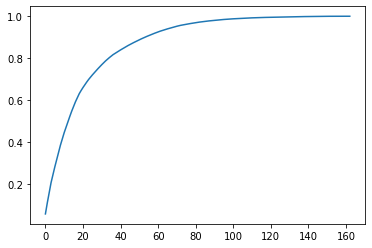

In [117]:
plt.plot(cumsum_hires)

## Plot

In [129]:
university_df = joined_hires_df_merged_subset

#### Get difference between median salary and salary for university

In [135]:
university_df = university_df[university_df.MEDIAN_SALARY.isnull() == False]

In [152]:
university_df.sort_values(by='total_hires', ascending=False)[:25]

,Institution,n_hires_His,n_hires_CS,n_hires_Bus,total_hires,hire_ratio,RPP_all,MEDIAN_SALARY,N_SALARIES,MEDIAN_SALARY_UPPER,MEDIAN_SALARY_LOWER,REAL_MEDIAN_SALARY,REAL_MEDIAN_SALARY_UPPER,REAL_MEDIAN_SALARY_LOWER,UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN,UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_UPPER,UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_LOWER,UNIVERSITY_SALARY_RELATIVE_MEDIAN,UNIVERSITY_SALARY_RELATIVE_MEDIAN_UPPER,UNIVERSITY_SALARY_RELATIVE_MEDIAN_LOWER
6,Stanford University,172.0,189.0,412.0,773.0,1.013106,126.7,62476.603840,349,63319.925605,62352.688787,49310.658122,49976.263303,49212.856186,-3064.957999,-2399.352818,-3162.759935,10048.909265,10892.231030,9924.994212
4,Harvard University,324.0,68.0,344.0,736.0,1.091988,115.5,55783.941620,493,56164.312487,55205.642506,48297.784952,48627.110378,47797.093079,-4077.831169,-3748.505743,-4578.523042,3356.247045,3736.617912,2777.947931
2,Massachusetts Institute of Technology,10.0,299.0,364.0,673.0,1.146508,115.5,56659.816586,680,56952.349035,56164.312487,49056.118257,49309.393104,48627.110378,-3319.497864,-3066.223017,-3748.505743,4232.122011,4524.654460,3736.617912
10,"University of California, Berkeley",246.0,204.0,221.0,671.0,0.736553,134.5,60413.982812,331,61417.398455,59110.348970,44917.459340,45663.493275,43948.214848,-7458.156781,-6712.122846,-8427.401273,7986.288237,8989.703880,6682.654395
0,University of Chicago,240.0,28.0,264.0,532.0,1.291262,102.8,57765.712798,699,59322.441677,56987.933045,56192.327624,57706.655328,55435.732534,3816.711503,5331.039207,3060.116413,5338.018222,6894.747102,4560.238469
14,"University of Michigan, Ann Arbor",173.0,64.0,282.0,519.0,0.608441,100.6,51964.730835,1205,51964.730835,51964.730835,51654.802023,51654.802023,51654.802023,-720.814098,-720.814098,-720.814098,-462.963740,-462.963740,-462.963740
3,University of Pennsylvania,128.0,84.0,279.0,491.0,1.108352,105.3,55205.642506,534,55913.661314,54938.156376,52427.010927,53099.393461,52172.988011,51.394806,723.777340,-202.628110,2777.947931,3485.966739,2510.461800
7,Columbia University,253.0,47.0,185.0,485.0,0.936293,125.7,53930.481535,471,54877.268858,53390.528986,42904.122144,43657.334016,42474.565621,-9471.493977,-8718.282105,-9901.050500,1502.786959,2449.574283,962.834410
1,Yale University,307.0,47.0,121.0,475.0,1.208651,106.2,53631.976988,583,54242.856101,53190.636555,50500.919951,51076.135688,50085.345155,-1874.696170,-1299.480433,-2290.270966,1204.282412,1815.161526,762.941979
16,University of Illinois at Urbana–Champaign,43.0,164.0,208.0,415.0,0.548942,91.0,51166.184180,381,51813.005959,51140.331792,56226.576022,56937.369186,56198.166804,3850.959901,4561.753065,3822.550683,-1261.510396,-614.688616,-1287.362783


In [136]:
university_df["REAL_MEDIAN_SALARY"]

0      56192.327624
1      50500.919951
2      49056.118257
3      52427.010927
4      48297.784952
           ...     
155    53542.910946
156    41585.252874
157    60035.463190
158    45165.164044
159    55918.467039
Name: REAL_MEDIAN_SALARY, Length: 114, dtype: float64

In [137]:
median_university_salary_real = np.median(university_df["REAL_MEDIAN_SALARY"])
median_university_salary_real

52375.61612102266

In [138]:
median_university_salary = np.median(university_df["MEDIAN_SALARY"])
median_university_salary

52427.69457529251

In [139]:
university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"] = (
    university_df["REAL_MEDIAN_SALARY"] - median_university_salary_real
)
university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_UPPER"] = (
    university_df["REAL_MEDIAN_SALARY_UPPER"] - median_university_salary_real
)
university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_LOWER"] = (
    university_df["REAL_MEDIAN_SALARY_LOWER"] - median_university_salary_real
)

<ipython-input-139-4cd241745f49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"] = (
<ipython-input-139-4cd241745f49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_UPPER"] = (
<ipython-input-139-4cd241745f49>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [140]:
university_df["UNIVERSITY_SALARY_RELATIVE_MEDIAN"] = university_df["MEDIAN_SALARY"] - median_university_salary
university_df["UNIVERSITY_SALARY_RELATIVE_MEDIAN_UPPER"] = (
    university_df["MEDIAN_SALARY_UPPER"] - median_university_salary
)
university_df["UNIVERSITY_SALARY_RELATIVE_MEDIAN_LOWER"] = (
    university_df["MEDIAN_SALARY_LOWER"] - median_university_salary
)

<ipython-input-140-53d4ec65084a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_df["UNIVERSITY_SALARY_RELATIVE_MEDIAN"] = university_df["MEDIAN_SALARY"] - median_university_salary
<ipython-input-140-53d4ec65084a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_df["UNIVERSITY_SALARY_RELATIVE_MEDIAN_UPPER"] = (
<ipython-input-140-53d4ec65084a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [173]:
nex = 10
top_n = 150

In [174]:
import seaborn as sns

In [175]:
pal = sns.color_palette('Set1', 10)
pal

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

[Text(0, 0, '-$10k'),
 Text(0, 0, '-$5k'),
 Text(0, 0, '$0'),
 Text(0, 0, '$5k'),
 Text(0, 0, '$10k')]

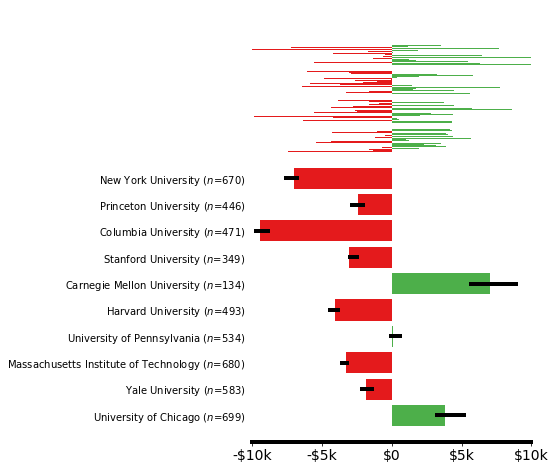

In [176]:
sort_mask = np.argsort(university_df["hire_ratio"].values)[::-1]
fig, axs = plt.subplots(
    nrows=2,
    figsize=(5, 8),
    gridspec_kw={"wspace": 0, "hspace": 0, "height_ratios": [1, 2]},
)

ax = axs[0]
y = university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"].values[sort_mask][nex:top_n]
ax.barh(
    np.arange(len(university_df))[nex:top_n],
    y,
    color=[pal[2] if np.sign(i) > 0 else pal[0] for i in y],
)
ax.set_xlim([-10000, 10000])
ax.set_ylim([nex, top_n])
# ax.set_xticks([])
[i.set_linewidth(0.0) for i in ax.spines.values()]
ax.set_yticks([])
ax.set_xticks([])

ax = axs[1]
y = university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"].values[sort_mask][:nex]
ax.barh(
    np.arange(len(university_df))[:nex] + 1,
    y,
    color=[pal[2] if np.sign(i) > 0 else pal[0] for i in y],
)
[i.set_linewidth(0.0) for i in ax.spines.values()]
ax.tick_params(left=False)

xerr = np.array((
        y - university_df.UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_LOWER.values[sort_mask][
            :nex
        ],
        y - university_df.UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_UPPER.values[sort_mask][
            :nex
        ],
    ))
xerr[1,:] *= -1
ax.errorbar(
    y,
    np.arange(len(university_df))[:nex] + 1,
    xerr=xerr,
    ls='none',
    color = 'k',
    lw = 4
    
)

# ax.axvline(0, color="k", ls="dashed")
# ax.set_xlabel('University ranking (ranked)')
# ax.set_ylabel('Regional salary value relative median ($)')
# ax.set_yscale('log')
ax.set_xlim([-10000, 10000])
ax.set_ylim([0, nex + 1])
# ax.set_xticks([])
ax.set_yticks(np.arange(1, nex + 1))

names = [
    "{} ($n$={})".format(i, j)
    for i, j in zip(
        university_df["Institution"].values[sort_mask][:nex],
        university_df["N_SALARIES"].values[sort_mask][:nex],
    )
    
]
ax.set_yticklabels(names)
# ax.set_yticklabels(university_df["institution"].values[sort_mask][:20])
ax.spines["bottom"].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xticks([-10000, -5000, 0, 5000, 10000])
ax.set_xticklabels(["-$10k", "-$5k", "$0", "$5k", "$10k"])
#save_fig(FIGURE_DIR / 'institution_real salary')

[Text(0, 0, '-$10k'),
 Text(0, 0, '-$5k'),
 Text(0, 0, '$0'),
 Text(0, 0, '$5k'),
 Text(0, 0, '$10k')]

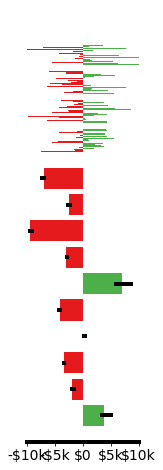

In [177]:
sort_mask = np.argsort(university_df["hire_ratio"].values)[::-1]
fig, axs = plt.subplots(
    nrows=2,
    figsize=(2, 8),
    gridspec_kw={"wspace": 0, "hspace": 0, "height_ratios": [1, 2]},
)

ax = axs[0]
y = university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"].values[sort_mask][nex:top_n]
ax.barh(
    np.arange(len(university_df))[nex:top_n],
    y,
    color=[pal[2] if np.sign(i) > 0 else pal[0] for i in y],
)
ax.set_xlim([-10000, 10000])
ax.set_ylim([nex, top_n])
# ax.set_xticks([])
[i.set_linewidth(0.0) for i in ax.spines.values()]
ax.set_yticks([])
ax.set_xticks([])

ax = axs[1]
y = university_df["UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN"].values[sort_mask][:nex]
ax.barh(
    np.arange(len(university_df))[:nex] + 1,
    y,
    color=[pal[2] if np.sign(i) > 0 else pal[0] for i in y],
)
[i.set_linewidth(0.0) for i in ax.spines.values()]
ax.tick_params(left=False)

xerr = np.array((
        y - university_df.UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_LOWER.values[sort_mask][
            :nex
        ],
        y - university_df.UNIVERSITY_REAL_SALARY_RELATIVE_MEDIAN_UPPER.values[sort_mask][
            :nex
        ],
    ))
xerr[1,:] *= -1
ax.errorbar(
    y,
    np.arange(len(university_df))[:nex] + 1,
    xerr=xerr,
    ls='none',
    color = 'k',
    lw = 4
    
)

# ax.axvline(0, color="k", ls="dashed")
# ax.set_xlabel('University ranking (ranked)')
# ax.set_ylabel('Regional salary value relative median ($)')
# ax.set_yscale('log')
ax.set_xlim([-10000, 10000])
ax.set_ylim([0, nex + 1])
# ax.set_xticks([])
if False:
    ax.set_yticks(np.arange(1, nex + 1))
    names = [
        "{} ($n$={})".format(i, j)
        for i, j in zip(
            university_df["INSTNM"].values[sort_mask][:nex],
            university_df["N_SALARIES"].values[sort_mask][:nex],
        )

    ]
    ax.set_yticklabels(names)
else:
    ax.set_yticks([])
# ax.set_yticklabels(university_df["institution"].values[sort_mask][:20])
ax.spines["bottom"].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xticks([-10000, -5000, 0, 5000, 10000])
ax.set_xticklabels(["-$10k", "-$5k", "$0", "$5k", "$10k"])
#save_fig(FIGURE_DIR / 'institution_real salary')